# Тема 03. Методы оптимизации
Для обучения нейронной сети мы создаем некоторую функцию ошибки и оптимизируем ее - ищем такие параметры, для которых значение ошибки будет как можно меньше. 

Для поиска минимумов функции хорошо подходит метод градиентного спуска, вспомним, как он устроен, обсудим проблемы и модификации такого метода. 

Для наглядности будем выполнять оптимизацию двумерной функции "Банан Розенброка" используя TensorFlow.

In [ ]:
# Подключим все необходимые библиотеки
#!pip install tensorflow-gpu==2.0.0-beta0 > /dev/null 2>&1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline

display.clear_output()

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

TensorFlow executing eagerly: True


## Тестовая функция "Банан Розенброка" 🍌

Для наглядного сравнения методов оптимизации будем использовать функцию "Банан Розенброка":

\begin{equation}
f(x,y) = (a-x)^2+b\times(y-x^2)^2
\end{equation}

с параметрами  $a=1$ и $b=20$ .

 Глобальный минимум этой функции находится в точке $(a, a^2)$, в нашем случае в  $(1, 1)$. 


In [ ]:
# Тестовая функция
def rosenbrock_banana(x, y, a=1., b=20.):
  return tf.math.pow(a - x, 2.) + b * tf.math.pow(y - tf.math.pow(x, 2.), 2.)

Нарисуем этот банан 🍌 контурным графиком:

In [ ]:
# функция для расчета поверхности 
def gen_2d_loss_surface(loss_func,
             n_x=100, # число точек по оси x
             n_y=100, # число точек по оси y
             min_x=-2., max_x=2., # крайние точки оси x
             min_y=-0.2, max_y=1.3 # крайние точки оси y
            ):
  
  # сетка расчетных точек
  X, Y = np.meshgrid(np.linspace(min_x, max_x, n_x),
                     np.linspace(min_y, max_y, n_y))
  # расчитываем значение функции на этой сетке
  Z = loss_func(X, Y).numpy()
  
  return X, Y, Z

# функция для рисования контуров, принимает число уровней контура  
def make_contour_plot(X, Y, Z, levels=None):
  if levels == None:
    # по умолчанию 20 уровней контура в логариммической (log) шкале
    levels = np.insert(np.logspace(0, 2.6, 20, True, base=10), 0, 0)
    
  fig = plt.figure(figsize=(9.84, 3))
  ax = fig.gca()
  # рисуем контуры 
  ax.contour(X, Y, Z, levels, alpha=0.5)
  ax.contourf(X, Y, Z, levels, alpha=0.2)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  
  return fig, ax

# функция для рисования поверхности
def make_surface_plot(X, Y, Z, elevation=0, azimuth_angle=0, levels=None):
  
  if levels == None:
    # по умолчанию 20 уровней контура в логарифмической шкале
    levels = np.insert(np.logspace(0, 2.6, 20, True, base=10), 0, 0)
    
  fig = plt.figure(figsize=(10,6))
  ax = fig.gca(projection='3d')
  ax.view_init(elevation, azimuth_angle)
  # рисуем поверхность
  ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.2)
  # и контуры на ней
  ax.contour(X, Y, Z, levels, cmap='viridis', alpha=0.5)
  
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  
  return fig, ax


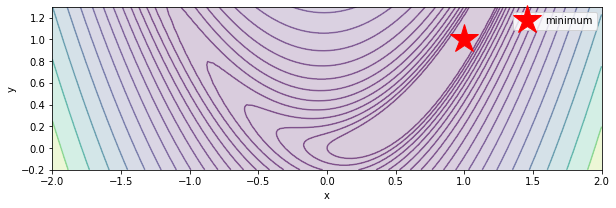

In [ ]:
# создаем и рисуем контуры
X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
fig, ax = make_contour_plot(X, Y, Z)

# маркер минимума функции
ax.plot(1, 1, 'r*', ms=30, label='minimum') 
ax.legend()

fig.show()

Рисуем поверхность:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


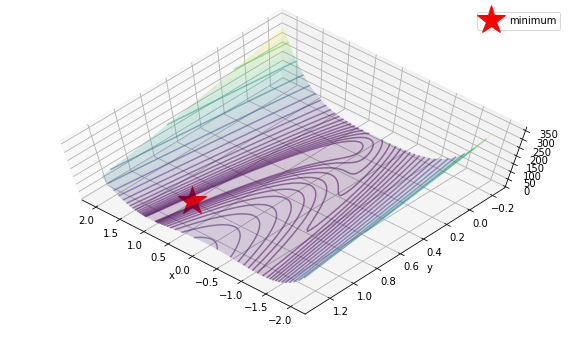

In [ ]:
#@title {run: "auto"}

elevation = 71 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 132 #@param {type:"slider", min:0, max:360, step:1}
  
X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([1], [1], 'r*', zs=[0], zdir='z', ms=30, label='minimum')
ax.legend()

fig.show()

Контур долины такой функции чем-то напоминает банан. 

Найти дно такой долины не трудно, но вот найти глобальный минимум в ней может быть сложнее.


## Градиент

### Что такое вектор градиента?

Пусть задана некоторая функция  $f$, которая отображает вход $x$ в выход $y$: $$y = {f(x)}$$

Функция $f$ может быть любой, полиномиальной, экспоненциальной и др.

Можно _приблизить_ функцию $f$ в окрестности некоторой точки $x_0$ с помощью прямой (линейной) функции ${df}$:

$${df(x)} = f(x_0) + {f'(x_0)}(x - x_0)$$
<center>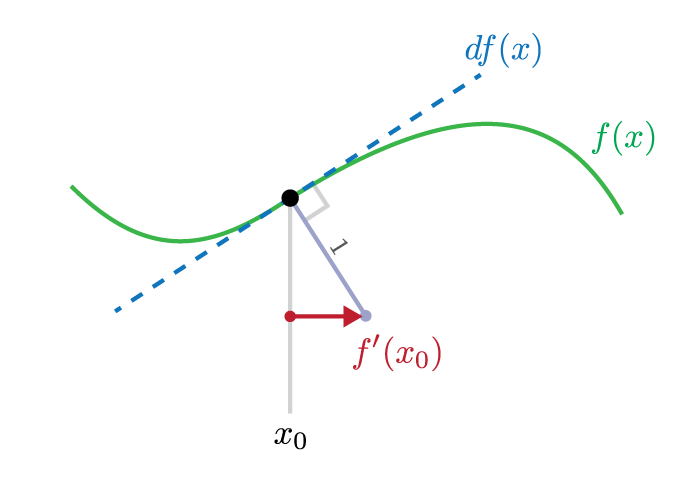</center>

Можно использовать величину $f' = \frac{dy}{dx}$ для приближения функции $f$ в окрестности точки $x_0$. Это производная функции, которая фактически показывает _наклон_ приближающей прямой, если, скажем, функция была бы горизонтальна в точке $x_0$, то, ее производная  ${f'(x_0)}$ была бы нулевой.

Заметьте, что производная ${f'(x_0)}$ показывает _направление_ в котором функция ${f(x)}$ _возрастает_, а величина производной показывает _как быстро_ функция возрастает.

Построим интерактивный график, показывающий производную ${f'(x_0)}$ функции ${f(x)}$ в точке $x_0$ (изменяйте). 

In [ ]:

# функция
def f(x):
  return -np.cos(x)
# ее производная
def tangent_f(x):
  return np.sin(x)
# касательная
def df(x, x_0):
  return tangent_f(x_0) * (x - x_0) + f(x_0)
# нормаль
def perpindicular_unit_f(x_0):
  slope_f = tangent_f(x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

# визуализация
def interactive_gradient_visual(x_0):
  # 
  init_size = plt.rcParams["font.size"] # 
  plt.rcParams.update({'font.size': 22}) # 
  
  plt.figure(figsize=(12, 8))
  
  x = np.linspace(-np.pi, 2 * np.pi)
  f_x = f(x)
  
  # рисуем f(x)
  plt.plot(x, f_x, label=r"$f(x)$", color="green")
  
  # точка x_0 на f(x)
  plt.plot(x_0, f(x_0), marker="o", color="black")
  
  # касательная f(x) в x_0
  plt.plot(x, df(x, x_0), linestyle="--", color="cornflowerblue", label=r"$df(x)$")
  
  # нормаль
  perp_unit_vector = perpindicular_unit_f(x_0)
  plt.plot(perp_unit_vector[0], perp_unit_vector[1], color="dimgray")
  
  # вертикальная линия из x_0
  plt.plot([x_0, x_0], [f(x_0), -3.1], color="silver")
  
  # положительное направление изменения вектора
  [[x_0, x_1], [y_0, y_1]] = perp_unit_vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="red", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="red", label=r"$f'(x_0)$")
  
  plt.legend(loc="upper left")
  plt.xlim(-3.1, 6.2)
  plt.ylim(-3.1, 3.1)
  plt.xlabel(r"$x_0$")
  plt.show()
  
  # 
  plt.rcParams.update({'font.size': init_size})

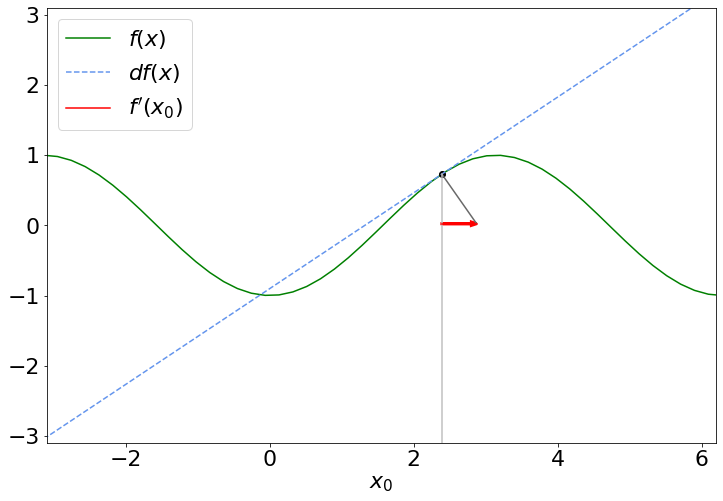

In [ ]:
#@title {run: "auto"}
x_0 = 2.39 #@param {type:"slider", min:-3.1, max:6.2, step:0.01}

interactive_gradient_visual(x_0)

#### Пространства большей размерности


Точно также градиент определяется в пространствах большей размерности, только теперь мы работаем с *вектором*, а не скаляром. Произведение скаляров производной ${ f'(x_0) }$ и разности $(x - x_0)$ заменяется на *скалярное произведение* *векторов* градиента ${\nabla f(\vec x_0)}$ и разности $(\vec x - \vec x_0)$:

$${df(\mathbf x)} = f(\mathbf x_0) + {\nabla f(\mathbf x_0)}\cdot (\mathbf x - \mathbf x_0)$$

<center>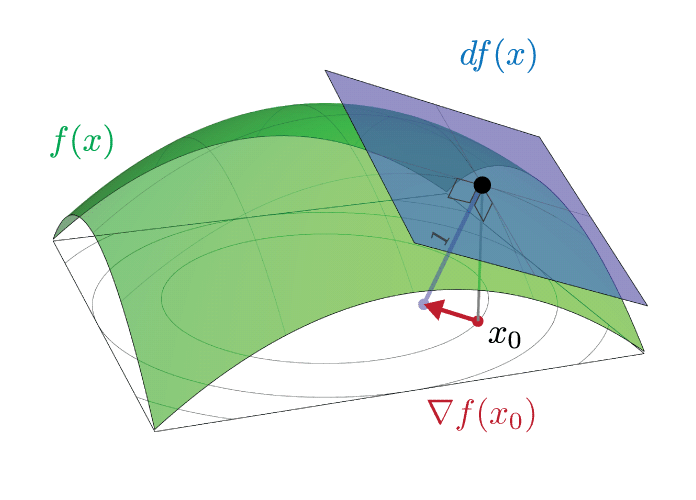</center>


Теперь вектор градиента показывает *наклон плоскости*, которая приближает поверхность $f$ в окрестности точки $x_0$ и указывает в направлении наискорейшего возрастания функции. Аналогично вводится градиент для пространств любой размерности.

## Градиентный спуск

**Градиентный спуск** это один из простейших и важнейших методов оптимизации и обучения. Является основой для многих более сложных методов. 

Математически выражается в виде:

\begin{equation}
\mathbf{θ}= \mathbf{θ} −\eta \times \nabla_\mathbf{θ} J(\mathbf{θ})
\end{equation}

здесь $\mathbf{θ}$ обучаемые параметры модели, $\eta$ (эта) величина шага обучения (learning rate), $J(\mathbf{θ})$ функция ошибки (часто обозначается как $\mathcal{L}$), а $\nabla_\theta J(\mathbf{θ})$ **градиент** функции ошибки по обучаемым параметрам. 

Для обучения параметров мы вычисляем градиент, масштабируем его величиной шага и изменяем параметры на такую величину с противоположным знаком. Знак противоположен, поскольку мы ищем минимум функции ошибки, т.е. двигаемся в сторону уменьшения ее, тогда как градиент показывает, в каком направлении ошибка увеличивается. 


Можно различить несколько вариантов применения метода градиентного спуска:

1.   Используем размер пакета $n$, где $n$ число обучающих примеров, это оффлайн реализация (**Batch Gradient Descent (BGD)**). Т.е. используем все примеры для вычисления градиента, накапливаем изменения от каждого примера, и только после этого изменяем параметры. 

2.   Если размер пакета равен 1, метод называют стохастическим градиентным спуском (**Stochastic Gradient Descent (SGD)**). Здесь мы выбираем, обычно случайно, только один пример из данных, вычисляем градиент для этого примера и сразу же изменяем параметры модели. Это онлайн обучение.

3.   Наконец, при размере пакета $m < n$ метод называют пакетным градиентным спуском (**Mini-batch Gradient Descent**), он является компромисом между онлайн и офлайн подходом. Здесь берут некоторый пакет примеров, вычисляют и накапливают градиент для всех примеров из этого пакета и только после этого изменяют параметры (часто именно этот вариант метода относят к SGD).


Размер пакета примеров влияет на результат обучения, и этот размер нужно выбирать. Некоторые исследования можно найти [здесь](https://arxiv.org/pdf/1803.09820.pdf), [здесь](https://arxiv.org/abs/1606.04838)  и [здесь](https://blog.janestreet.com/does-batch-size-matter/), но какой-то универсальной рекомендации дать нельзя. Размер пакета это еще один гиперпараметр, который нужно подбирать.


SGD не зря называют стохастическим. Часто бывает так, что данные зашумлены, одному и тому же входу могут отвечать немного различающиеся выходы, SGD же очень чувствителен в шуму. Нужно регулировать размер пакета, что может помочь в лучшей оценке градиента в среднем. В примере ниже для выбранной точки $x_0$ будет зашумляться величина функции ${f(x)}$, синим показаны настоящие, без учета шума, касательная ${df(x)}$ и градиент ${{f'}(x_0)}$, а красным цветом вычисленные по зашумленным данным ${\tilde{df}(x)}$ и ${\tilde{f'}(x_0)}$. Регулируйте размер пакета *batch_size* и посмотрите как он влияет на точность оценки градиента.

In [ ]:
#@title Вспомогательные функции, запустите (double click to unhide/hide the code)
def f(x):
  return -np.cos(x)

def tangent_f(x):
  return np.sin(x)

def df(x, x_0):
  return tangent_f(x_0) * (x - x_0) + f(x_0)

def perpindicular_unit_f(x_0):
  slope_f = tangent_f(x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

def noisy_df(x, x_0, noisy_x_0):
  return tangent_f(noisy_x_0) * (x - x_0) + f(x_0)

def noisy_perpindicular_unit_f(x_0, noisy_x_0):
  slope_f = tangent_f(noisy_x_0)
  y_0 = f(x_0)
  
  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f
  
  return [[x_0, x_1], [y_0, y_1]]

def interactive_noisy_gradient_visual(x_0, noisy_x_0):
  # change the fontsize for better visibility
  init_size = plt.rcParams["font.size"] # store initial font size
  plt.rcParams.update({'font.size': 22}) # update the size
  
  plt.figure(figsize=(12, 8))
  
  x = np.linspace(-np.pi, 2 * np.pi)
  f_x = f(x)
  y_0 = f(x_0)
  
  # plot f(x)
  plt.plot(x, f_x, label=r"$f(x)$", color="green")
  
  # add a point showing where x_0 falls on f(x)
  plt.plot(x_0, f(x_0), marker="o", color="black")
  
  # plot the tangent line to f(x) at x_0
  plt.plot(x, df(x, x_0), linestyle="--", color="cornflowerblue", label=r"$df(x)$")
  
  # drop a vertical line from x_0
  plt.plot([x_0, x_0], [f(x_0), -3.1], color="silver")
  
  # plot the noisy tangent line to f(x) at x_0
  plt.plot(x, noisy_df(x, x_0, noisy_x_0), linestyle="--", color="red", label=r"$\widetilde{df}(x)$")
  
  # plot the normal vector to the tangent
  [[x_0, x_1], [y_0, y_1]] = perpindicular_unit_f(x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")
  
  # plot the positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="blue", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="blue", label=r"$f'(x_0)$")
  
  # plot the noisy normal vector to the tangent
  [[noisy_x_0, x_1], [noisy_y_0, y_1]] = noisy_perpindicular_unit_f(x_0, noisy_x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")
  
  # plot the noisy positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="red", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="red", label=r"$\widetilde{f'}(x_0)$")
  
  
  plt.legend(loc="upper left")
  plt.xlim(-3.1, 6.2)
  plt.ylim(-3.1, 3.1)
  plt.xlabel(r"$x_0$")
  plt.show()
  
  # reset to initial font size
  plt.rcParams.update({'font.size': init_size})

def interactive_batch_size_visual(x_0, batch_size):
  np.random.seed(0)
  noisy_x_0 = x_0 + np.mean(np.random.normal(loc=0, scale=0.5, size=batch_size))
  interactive_noisy_gradient_visual(x_0, noisy_x_0)

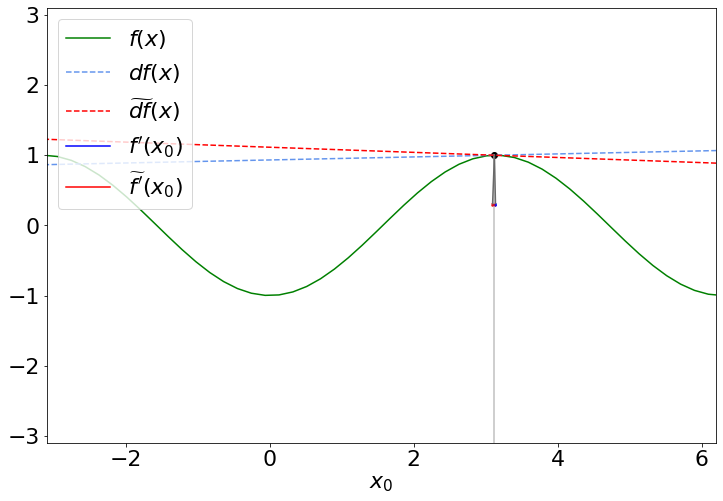

In [ ]:
#@title  {run: "auto"}
x_0 = 3.12 #@param {type:"slider", min:-3.1, max:6.2, step:0.01}
batch_size = 163 #@param {type:"slider", min:1, max:256, step:1}

interactive_batch_size_visual(x_0, batch_size)

### Реализация SGD

Метод SGD довольно прост, как и его реализация.

In [ ]:
def SGD_update(params, grads, states, hyper_params):
  # params - обучаемые параметры, прошлое значение
  # grads - градиент
  # states - состояние, здесь не используется
  # hyper_params - гиперпараметры
    #  lr: learning_rate=0.01
  for param, grad in zip(params, grads):
    param.assign_sub(hyper_params['lr'] * grad) # функция TF для обновления параметров вычитанием

Посмотрим, как работает этот метод для "Банана".

Команда GradientTape() заставляет TF сохранять граф вычислений, чтобы потом использовать его для автодифференцирования, переменные должны быть объявлены как Variable. Команда gradient() вычисляет градиент.


In [ ]:
# функция для оптимизации и рисования
def optimize_banana(update_func, # метод обучения
                    params, # обучаемые параметры,
                    states, # состояние метода
                    hyper_params, # гиперпараметры
                    add_gradient_noise=False # добавлять ли шум в градиент
                    ):

  # рисование поверхности, контуров
  X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
  fig, ax = make_contour_plot(X, Y, Z)
  ax.plot(1, 1, 'r*', ms=30, label='minimum')  # точка минимума
  ax.plot(start_x, start_y, 'b*', ms=20, label='start') # начальная точка
  # цикл по количеству эпох
  for epoch in range(epochs):
    with tf.GradientTape() as tape: # включаем запись графа вычислений
      
      if add_gradient_noise:
        # если задано, добавляем шум в функцию, здесь только в аргумент  b
        loss = rosenbrock_banana(x, y, b=(20.0+np.random.normal())) # оптимизируемая функция
      else:
        loss = rosenbrock_banana(x, y) # а иначе не добавляем шум
      
    # вычисляем градиент функции по отношению к заданным параметрм
    grads = tape.gradient(loss, params)
    
    # сохраняем старые значения x и y для рисования
    old_x = params[0].numpy()
    old_y = params[1].numpy()

    # обновляем параметры указанным методом
    update_func(params, grads, states, hyper_params)

    # рисуем изменения x и y для каждого шага
    ax.annotate('', xy=(x.numpy(), y.numpy()),
                xytext=(old_x, old_y),
              arrowprops={'arrowstyle': '->', 'color': 'k', 'lw': 1},
                   va='center', ha='center')  
  # рисуем результат
  ax.plot(x.numpy(), y.numpy(), 'g*', ms=20, label='end')
  ax.legend()

  fig.show()

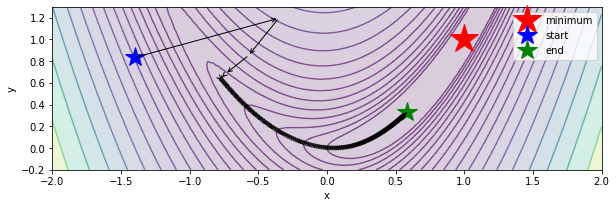

In [ ]:
#@title SGD {run: "auto"}
start_x = -1.4 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.83334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.008 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 150 #@param {type:"slider", min:1, max:150, step:1}
add_gradient_noise= False #@param {type:"boolean"}

# Объявляем переменные как Variable, чтобы сохранялся граф вычислений с ними
x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y] # обучаемые параметры
states = [] # состояние, здесь нет.
hyper_params = {"lr": learning_rate} # гиперпараметры

optimize_banana(SGD_update, params, states, hyper_params, add_gradient_noise=add_gradient_noise)

## Проблемы градиентного спуска

Градиентный спуск сам по себе не очень хороший метод для обучения, у него есть много проблем, например:
- застревает в локальных минимумах: если у функции ошибки несколько минимумов, то дойдя до одного из них, производная станет равна 0 и параметр больше изменяться не будет, но этот минимум может оказаться не самым лучшим.
- необходимо задавать начальные значения параметров: вспомните формулу, из "старых" значений вычитаем производную, перед началом обучения эти самые "старые" значения должны уже быть определены. И от выбора начальных значений параметров будет зависеть результат обучения.
- надо задавать величину шага (число "эта" в формуле): слишком маленькое - будем очень долго идти к минимуму, очень большое - проскочим его.
- и другие

Поэтому используют множество разных модификаций градиентного спуска, в которых добавляют новые члены в формулу, придумывают как изменять шаг, как ограничить параметры и прочее.
Мы рассмотрим только идеи этих методов, важно что все они основаны на градиентном спуске и используют производную (градиент), вычисляемую с помощью метода обратного распространения ошибки. Можно посмотреть, например, здесь про разные методы: https://ruder.io/optimizing-gradient-descent/  

Нет какого-то одного "лучшего" метода обучения, придется экспериментировать и использовать различные.

## Знак градиента
Простой способ защититься от сильного уменьшения градиента в долинах - использовать только знак градиента, а не его величину. Но поможет ли это... 


In [ ]:
def SGD_sign_update(params, grads, states, hyper_params):
  # params - обучаемые параметры, прошлое значение
  # grads - градиент
  # states - состояние, здесь не используется
  # hyper_params - гиперпараметры
    #  lr: learning_rate=0.01
  for param, grad in zip(params, grads):
    param.assign_sub(hyper_params['lr'] * tf.math.sign(grad)) # функция TF для обновления параметров вычитанием

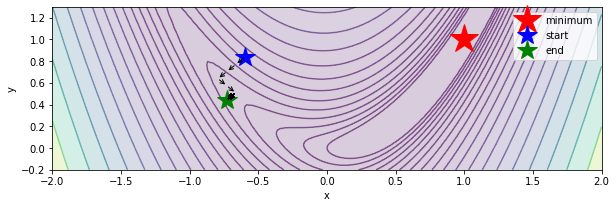

In [ ]:
#@title SGD_sign {run: "auto"}
start_x = -0.6 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.83334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.065 #@param {type:"slider", min:0, max:0.2, step:0.0005}
epochs = 234 #@param {type:"slider", min:1, max:300, step:1}
add_gradient_noise= False #@param {type:"boolean"}

# Объявляем переменные как Variable, чтобы сохранялся граф вычислений с ними
x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y] # обучаемые параметры
states = [] # состояние, здесь нет.
hyper_params = {"lr": learning_rate} # гиперпараметры

optimize_banana(SGD_sign_update, params, states, hyper_params, add_gradient_noise=add_gradient_noise)

В таком методе величина, на которую изменяются параметры, задается только шагом learning_rate, знак градиента же лишь показывает прибавлять или вычитать эту величину. 

## SGD с моментом

Cерьезная проблема для градиента это "долины" - протяженные области в которых величина функции меняется очень медленно. Здесь производная может быть близка к нулю. При маленькой производной и изменения параметров будут маленькими, можем просто не дождаться когда достигнем минимума.

Но если мы знаем, что на предыдущих шагах двигались преимущественно в одну сторону, то логично предположить, что и на последующих шагах будем туда же двигаться. Давайте запомним направление нашего прошлого движения и ускорим движение по нему на следующем шаге. Так получилcя метод SGD с **моментом**. Момент это импульс, если нашу точку представить как катящийся по поверхности шарик, то он стремится сохранить траекторию своего движения (а если бы поверхность была плоской, то катился бы по прямой), это закон сохранения импульса. Для оптимизации применяют ту же идею, давайте сохраним предыдущие изменения параметров $ \Delta \mathbf{θ} $ с некоторым коэффициентом $ \gamma$ :

\begin{align}
\Delta \mathbf{θ} &= \gamma \Delta \mathbf{θ} + \eta \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf{θ} &= \mathbf{θ} − \Delta \mathbf{θ}
\end{align}

здесь $\Delta \mathbf{θ}$ изменения параметров $\mathbf{θ}$ на каждом шаге получаются из прошлых изменений (которые необходимо запоминать) и градиента. Коэффициент $\gamma$ (gamma) это *величина момента* ,  $\eta$ шаг обучения.

Теперь предыдущие изменения параметров должны запоминаться и сохраняться для следующей итерации, у метода появляется _состояние_ states. 

### Реализация SGD с моментом

In [ ]:
def momentum_update(params, grads, states, hyper_params):
  # типичные значения гиперпараметров: learning_rate=0.01, momentum=0.9
  changes = states['changes'] # состояние метода, будут запоминаться текущие изменения параметров для следующей итерации
  for param, grad in zip(params, grads):
    # добавляем момент  и градиент
    changes[param.ref()].assign(hyper_params['momentum'] * changes[param.ref()] + # момент
                          hyper_params['lr'] * grad)                              # градиент
    param.assign_sub(changes[param.ref()])

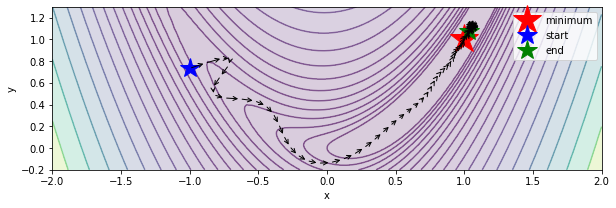

In [ ]:
#@title SGDM{run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.0045 #@param {type:"slider", min:0, max:0.02,step:0.0005}
momentum = 0.91 #@param {type:"slider", min:0, max:0.99, step:0.01}
epochs = 100 #@param {type:"slider", min:1, max:150,step:1}

x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
# состояния обнуляем перед началом работы
# они тоже являются массивами Variable
changes = {param.ref(): tf.Variable(0., dtype='float32') for param in params}
hyper_params = {"lr": learning_rate, "momentum": momentum}
states = {"changes": changes}

optimize_banana(momentum_update, params, states, hyper_params, add_gradient_noise=False)

## RMSProp (Root Mean Square Propagation)

В предыдущих методах мы сами задавали величину шага  $\eta$, при этом она была одинакова для всех примеров и параметров. Но давайте задумаемся:

1.   Должны ли веса изменяться в одинаковом темпе?
2.   Должен ли этот темп не меняться в процессе обучения? 

Придумайте примеры, когда это явно не так.

В методе RMSProp как раз и реализована возможность изменения темпа. Математически он выглядит так:

\begin{align}
\mathbf{v} &= \gamma \mathbf{v} + (1 - \gamma) (\nabla_\mathbf{θ} J(\mathbf{θ}))^2 \\
\mathbf{θ} &= \mathbf{θ} − \frac{\eta}{\sqrt{\mathbf{v}} + \mathbf{\epsilon}} \nabla_\mathbf{θ} J(\mathbf{θ})
\end{align}

Здесь $\mathbf{v}$ это оценка квадрата градиента (читай, величины) для каждого параметра, вычисленная как скользящее среднее, $\gamma$ коэффициент забывания в скользящем среднем, а $\mathbf{\epsilon}$ (epsilon) некоторое малое число, чтобы не делить на ноль. 

RMSProp изменяет шаг обучения каждого параметра отдельно обратно пропорционально величине производной (т.е. чем больше накопленное значение производной, тем меньше шаг).  **У каждого параметра теперь свой собственный шаг, который изменяется и со временем**. Предыдущие значения средней величины квадрата градиента надо запоминать, это _состояние_ метода. 

### Реализация RMSProp

In [ ]:
def RMSProp_update(params, grads, states, hyper_params):
  # типичные значения гиперпараметров: learning_rate=0.001, gamma=0.9, eps=1e-8
  averages = states['averages'] # состояние - средняя величина квадрата градиента 
  for param, grad in zip(params, grads):
    averages[param.ref()].assign(hyper_params['gamma']*averages[param.ref()] +
                           (1 - hyper_params['gamma'])*tf.math.pow(grad, 2))
    param.assign_sub(hyper_params['lr']/(tf.sqrt(averages[param.ref()]) + hyper_params['eps'])*grad)

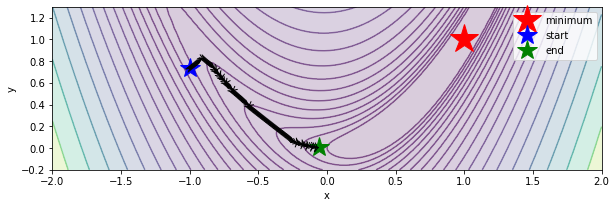

In [ ]:
#@title Double click to unhide/hide the code {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.007 #@param {type:"slider", min:0, max:0.02,step:0.0005}
gamma = 0.21 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}

x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
averages = {param.ref(): tf.Variable(0., dtype='float32') for param in params}
states = {"averages": averages}
hyper_params = {"lr": learning_rate, "gamma": gamma, "eps": 1e-8}
  
optimize_banana(RMSProp_update, params, states, hyper_params, add_gradient_noise=False)

## Метод Adam (Adaptive moment estimation)

В методе Adam скомбинированы идеи изменяемого шага и момента. Скользящим средним строится оценка квадрата градиента для настройки шага, и величины градиента для настройки момента с дополнительными коэФфициентами:

\begin{align}
\mathbf m &= β_1 \mathbf{m} + (1 − β_1)  \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf v &= β_2 \mathbf{v} + (1 − β_2) (\nabla_\mathbf{θ} J(\mathbf{θ}))^2 \\
\mathbf{\hat{m}} &= \frac{\mathbf{m}}{1 − β_1^t} \\
\mathbf{\hat{v}} &= \frac{\mathbf{v}}{1 − β_2^t} \\
\mathbf{θ} &= \mathbf{θ} − \frac{\eta}{\sqrt{\mathbf{\hat{v}}} + \mathbf{\epsilon}} \mathbf{\hat{m}}
\end{align}

здесь $\mathbf{m}$ скользящая оценка момента, $\mathbf{v}$ скользящая оценка квадрата градиента,  $\mathbf{\hat{m}}$ и $\mathbf{\hat{v}}$ скорректированные их версии, $\beta_i$ (beta) коэффициенты, смысл $\eta$ и $\epsilon$ как прежде, t - время (номер итерации).

Adam по сути оценивает первый (среднее) $\mathbf{m}$ и второй (разброс) $\mathbf{v}$ моменты  градиента.

Состояние описывается запомненными предыдущими значениями момента, квадрата градиента и времени.

### Реализация метода  Adam

In [ ]:
def Adam_update(params, grads, states, hyper_params):
  # типичные значения гиперпараметров: learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8
  t = states["t"]
  t.assign_add(1.0)  
  first_moments = states["first_moments"]
  second_moments = states["second_moments"]
  
  for param, grad in zip(params, grads):
    # обновляем среднее для первого момента
    first_moments[param.ref()].assign(hyper_params['beta1']*first_moments[param.ref()] + \
                           (1 - hyper_params['beta1'])*grad)
    
    # обновляем среднее для второго момента (квадрата градиента)
    second_moments[param.ref()].assign(hyper_params['beta2']*second_moments[param.ref()] + \
                           (1 - hyper_params['beta2'])*tf.math.pow(grad, 2))
    # обновляем параметры
    param.assign_sub(hyper_params['lr']/   \
                     (tf.sqrt(second_moments[param.ref()]/ \
                            (1-tf.math.pow(hyper_params['beta2'],t))) + hyper_params['eps'])*   \
                     (first_moments[param.ref()]/ \
                            (1-tf.math.pow(hyper_params['beta1'],t))))

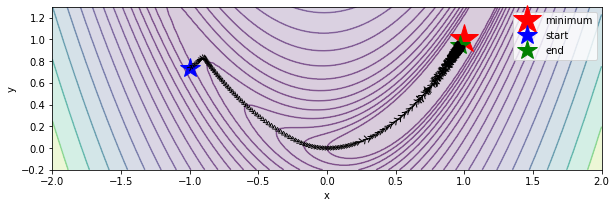

In [ ]:
#@title Adam {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.02 #@param {type:"slider", min:0, max:0.02,step:0.0005}
beta1 = 0.27 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
beta2 = 0.781 #@param {type:"slider", min:0.01, max:0.999, step:0.001}
epochs = 300 #@param {type:"slider", min:1, max:300,step:1}

x = tf.Variable(start_x, dtype='float32')  
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
first_moments = {param.ref(): tf.Variable(0., dtype='float32')
                 for param in params}
second_moments = {param.ref(): tf.Variable(0., dtype='float32')
                                     for param in params}
t = tf.Variable(0., dtype='float32')
states = {"first_moments": first_moments, 
          "second_moments": second_moments, "t": t}
hyper_params = {"lr": learning_rate, "beta1": beta1, "beta2": beta2, "eps": 1e-8}

optimize_banana(Adam_update, params, states, hyper_params)

## Изменение шага обучения

В методах  Adam и RMSProp шаг обучения уже не константа, вообще логично уменьшать шаг когда вы близки к минимуму, и увеличивать его, когда далеко. Предполагая, что чем больше проведем итераций тем ближе окажемся к минимуму, можно регулировать величину шага в зависимости от количества проведенных итераций, например, так:

\begin{equation}
  \eta = \eta \times \frac{1}{1 + \delta \times t}
\end{equation}

здесь $\eta$ шаг, $\delta$ (delta) коэффициент убывания, $t$ время (число итераций). Получим величину шага такой:

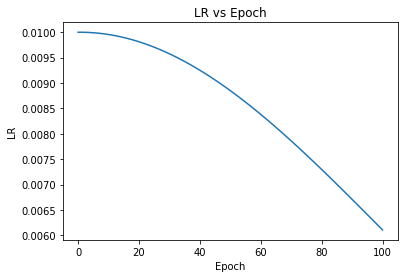

In [ ]:
initial_learning_rate = 0.01
epochs = 100
decay_rate = initial_learning_rate/epochs
learning_rates = [initial_learning_rate]

for t in range(epochs):
  previous_learning_rate = learning_rates[t]
  learning_rate_at_t = previous_learning_rate * 1/(1 + decay_rate * t)
  learning_rates.append(learning_rate_at_t)
  
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("LR vs Epoch")
plt.show()

Вводят "расписания" изменения шага, обычно применяют ступенчатое и экспоненциальное расписание, но, конечно, вы можете придумать свои:

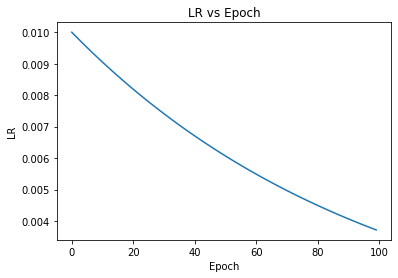

In [ ]:
# экспоненциальное затухание шага
initial_learning_rate = 0.01
epochs = 100
decay_rate = 0.01
learning_rates = []

for t in range(epochs):
  learning_rate_at_t = initial_learning_rate * np.exp(-decay_rate * t)
  learning_rates.append(learning_rate_at_t)
  
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("LR vs Epoch")
plt.show()

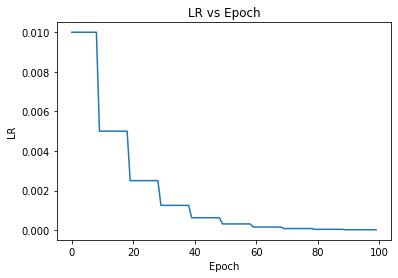

In [ ]:
# ступенчатое затухание шага
initial_learning_rate = 0.01
epochs = 100
epochs_wait = 10
decay_rate = 0.5
learning_rates = []

for t in range(epochs):
  exponent = np.floor((1 + t) / epochs_wait) # this part gives us the "steps"
  learning_rate_at_t = initial_learning_rate * np.power(decay_rate, exponent)
  learning_rates.append(learning_rate_at_t)
  
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("LR vs Epoch")
plt.show()


## Сравнение методов оптимизации

Не существует универсального метода оптимизации, который подошел бы для всех задач. В некоторых случаях даже простой SGD может оказаться лучше других, в некоторых - наоборот. Придется экспериментировать. Часто используют ADAM и во многих фреймворках он реализован по умолчанию. Давайте сравним методы для нашей задачи.

Конечно, все такие методы уже реализованы в Keras, давайте решим задачу классификации с их помощью. 

Сделаем маленький персептрон MLP и обучим его классифицировать тип одежды из набора  FashionMNIST. В этом наборе содержатся изображения  одежды, размер 28x28, серый.

4423680/4422102 [==============================] - 0s 0us/step


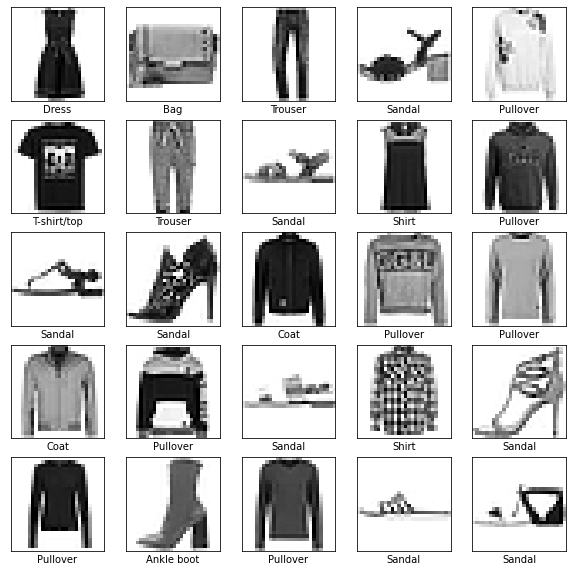

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline

fashion_mnist = tf.keras.datasets.fashion_mnist
# загружаем
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# названия классов
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap="gray_r")
    plt.xlabel(text_labels[train_labels[img_index]])

Выполним предобработку:

In [ ]:
batch_size = 128

# хранилище для данных, которое будет выдавать их пакетами
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# переводим в тип float32 и приводим к диапазону 0 ... 1
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))
# перемешиваем примеры.
train_ds = train_ds.shuffle(buffer_size=batch_size * 10)
# объединяем в пакеты 
train_ds = train_ds.batch(batch_size)

# тоже самое для тестовых данных
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))
test_ds = test_ds.batch(batch_size)


Создадим простой  MLP:

In [ ]:
def build_mlp():
  model = tf.keras.Sequential([ # последовательное подключение слоев
    tf.keras.layers.Flatten(input_shape=(28, 28)), # слой-выпрямитель, который только изменяет размеры массивов, двумерный переводит в одномерный.
    tf.keras.layers.Dense(128, activation='relu'), # скрытый слой
    tf.keras.layers.Dense(10, activation='softmax') # выходной слой, 10 нейронов по числу классов
  ])
  
  return model

model = build_mlp() # создаем модель

model.summary() # посмотрим на нее

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Будем обучать эту сеть MLP разными методами.

In [ ]:
# функция для рисования функции ошибки
def make_loss_plots(losses):
  plt.close()
  for label, loss_vals in losses.items():
    plt.plot(loss_vals, label=label)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss vs Epoch")
  plt.legend()
  plt.show()

Epoch 1/5
469/469 [==============================] - 6s 6ms/step - loss: 1.1017 - accuracy: 0.6584 - val_loss: 0.7840 - val_accuracy: 0.7378
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.6933 - accuracy: 0.7738 - val_loss: 0.6566 - val_accuracy: 0.7768
Epoch 3/5
469/469 [==============================] - 3s 5ms/step - loss: 0.6062 - accuracy: 0.8007 - val_loss: 0.6033 - val_accuracy: 0.7921
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.5601 - accuracy: 0.8138 - val_loss: 0.5647 - val_accuracy: 0.8056
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.5305 - accuracy: 0.8219 - val_loss: 0.5465 - val_accuracy: 0.8132


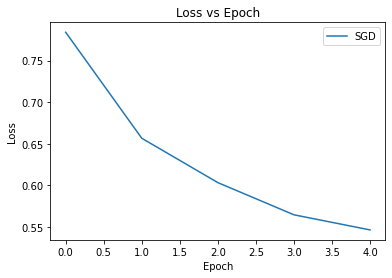

In [ ]:
losses = {}
tf.random.set_seed(0)

# Метод SGD
model = build_mlp() # создаем модель
model.compile(optimizer='sgd',  # метод обучения, значения гиперпараметров по умолчанию
              loss='sparse_categorical_crossentropy', # функция ошибки
              metrics=['accuracy']) # метрики
# обучаем и проверяем
sgd_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['SGD'] = sgd_hist.history["val_loss"]
make_loss_plots(losses) # рисуем



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.6434 - accuracy: 0.7808 - val_loss: 0.5292 - val_accuracy: 0.8148
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4629 - accuracy: 0.8384 - val_loss: 0.4533 - val_accuracy: 0.8402
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4182 - accuracy: 0.8541 - val_loss: 0.4448 - val_accuracy: 0.8419
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3940 - accuracy: 0.8618 - val_loss: 0.4473 - val_accuracy: 0.8393
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3774 - accuracy: 0.8669 - val_loss: 0.4022 - val_accuracy: 0.8576


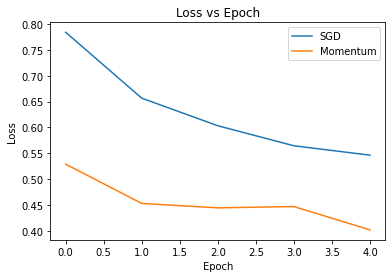

In [ ]:
# Метод SGD Momentum
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), #  укажем и гиперпараметры
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
momentum_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['Momentum'] = momentum_hist.history["val_loss"]
make_loss_plots(losses)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.5838 - accuracy: 0.7948 - val_loss: 0.5122 - val_accuracy: 0.8154
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4141 - accuracy: 0.8522 - val_loss: 0.4094 - val_accuracy: 0.8526
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3652 - accuracy: 0.8679 - val_loss: 0.3974 - val_accuracy: 0.8585
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3364 - accuracy: 0.8766 - val_loss: 0.3726 - val_accuracy: 0.8667
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3163 - accuracy: 0.8840 - val_loss: 0.3697 - val_accuracy: 0.8688


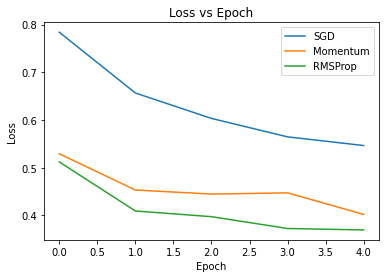

In [ ]:
# Метод RMSProp
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9),
              # rho - коэффициент забывания (обозначали как γ)
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
rmsprop_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['RMSProp'] = rmsprop_hist.history["val_loss"]
make_loss_plots(losses)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.5508 - accuracy: 0.8102 - val_loss: 0.4813 - val_accuracy: 0.8290
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4043 - accuracy: 0.8595 - val_loss: 0.4100 - val_accuracy: 0.8555
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3651 - accuracy: 0.8709 - val_loss: 0.3956 - val_accuracy: 0.8607
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3433 - accuracy: 0.8773 - val_loss: 0.3794 - val_accuracy: 0.8676
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3235 - accuracy: 0.8840 - val_loss: 0.3854 - val_accuracy: 0.8593


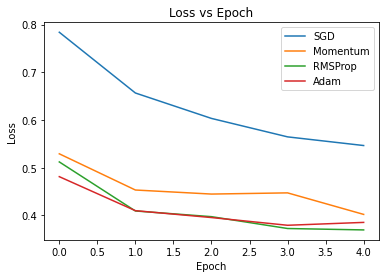

In [ ]:
# Метод Adam

model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
adam_hist = model.fit(train_ds, epochs=5,
            validation_data=test_ds)

losses['Adam'] = adam_hist.history["val_loss"]
make_loss_plots(losses)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.6585 - accuracy: 0.7649 - val_loss: 0.5764 - val_accuracy: 0.7699
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4476 - accuracy: 0.8421 - val_loss: 0.4632 - val_accuracy: 0.8344
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4214 - accuracy: 0.8518 - val_loss: 0.4507 - val_accuracy: 0.8375
Epoch 4/5
469/469 [==============================] - 3s 5ms/step - loss: 0.4086 - accuracy: 0.8555 - val_loss: 0.4426 - val_accuracy: 0.8404
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4005 - accuracy: 0.8583 - val_loss: 0.4357 - val_accuracy: 0.8425


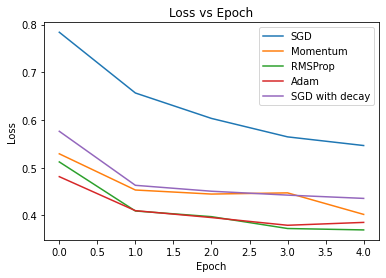

In [ ]:
# SGD с расписанием шага
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.5, momentum=0.0, decay=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
sgd_decay_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['SGD with decay'] = sgd_decay_hist.history["val_loss"]
make_loss_plots(losses)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.8438 - accuracy: 0.7066 - val_loss: 0.5760 - val_accuracy: 0.7789
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4928 - accuracy: 0.8214 - val_loss: 0.4800 - val_accuracy: 0.8326
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4298 - accuracy: 0.8485 - val_loss: 0.4594 - val_accuracy: 0.8390
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.4112 - accuracy: 0.8552 - val_loss: 0.4580 - val_accuracy: 0.8397
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.3993 - accuracy: 0.8587 - val_loss: 0.4518 - val_accuracy: 0.8415


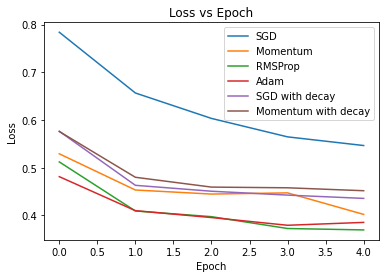

In [ ]:
# Momentum с расписанием
model = build_mlp()
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.5, momentum=0.9, decay=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
sgd_decay_hist = model.fit(train_ds, epochs=5,
          validation_data=test_ds)

losses['Momentum with decay'] = sgd_decay_hist.history["val_loss"]
make_loss_plots(losses)

## Другие методы

Число методов обучения велико. Постоянно придумывают всякие модификации, улучшения, но нет никакого универсального метода, который всегда был бы лучше других. Придется проводить эксперименты с разными, обычно начинают с метода ADAM, как наиболее популярного.

![img](https://cs231n.github.io/assets/nn3/opt2.gif)

Но можно придумать и другие идеи для методов обучения, кратко отметим:
- моменты [Нестерова(NAG)](http://ruder.io/optimizing-gradient-descent/): можно считать градиент не для текущей точки, а для той, в которую перешли бы, если бы двигались по инерции (моменту).
- методы второго порядка, когда поверхность приближается не плоскостью, а параболоидом, и находят минимум этого параболоида. Эти методы очень быстрые, но, к сожалению, хорошо работают только для пространств маленькой размерности, поскольку требуют огромного количества памяти и очень чувствительны к шумам. [Метод Ньютона](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) и  [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).
- различные комбинации всех методов и подходов.

Методы, основанные на градиенте, часто чувствительны к начальным значениям параметров, более корректный выбор их это тоже большое направление исследований, далеких от завершения. 

# Ссылки

Использованы и адаптированы материалы:

https://ruder.io/optimizing-gradient-descent/

https://colab.research.google.com/github/khipu-ai/practicals-2019/blob/master/1b_optimization.ipynb

